In [1]:
import pandas as pd
import numpy as np
import os
import sys
import polars as pl
import json
from joblib import Parallel, delayed
import deepchem
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Configure Polars 
cfg = pl.Config()
cfg.set_tbl_rows(20)
cfg.set_tbl_cols(50)
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, GroupShuffleSplit, ShuffleSplit, StratifiedKFold
import gc
import random

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/opt/conda/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'


In [2]:
PERCENTILES = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99]

In [3]:
def scatter_plot(x, y, show = True, xlabel = 'X', ylabel = 'Y', title = 'plot'):
    # Create the scatter plot
    plt.scatter(x, y)

    # Add labels and title for the axes
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Show the plot
    if show:
        plt.show()
        
        
def analyze_sample_weight(df):
    assert df.shape[0] == 98415610
    w_sum = df['sample_weight'].sum()
    for protein in ['BRD4', 'HSA', 'sEH']:
        print(protein, df.filter(pl.col(protein) == 1)['sample_weight'].sum() / w_sum)
    print('Union:', df.filter((pl.col('BRD4') + pl.col('HSA') + pl.col('sEH')) != 0)['sample_weight'].sum() / w_sum)

In [4]:
with open('/home/dangnh36/datasets/competitions/leash_belka/processed/meta/building_blocks.json', 'r') as f:
    bbs_meta = json.load(f)
    
for k, v in bbs_meta.items():
    print(k, '-->', len(v)) 

train_bbs --> 1145
train_bb1s --> 271
train_bb2s --> 693
train_bb3s --> 872
test_bb1s --> 341
test_bb2s --> 1140
test_bb3s --> 1389
test_bbs --> 2110
all_bbs --> 2110


In [11]:
train_scaffolds = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_scaffold.csv').collect()
train_df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_v2.csv')\
    .select(
        pl.col('molecule'),
        pl.col('bb1', 'bb2', 'bb3').cast(pl.UInt16),
        pl.col('BRD4', 'HSA', 'sEH').cast(pl.UInt8),
        scaffold_idx = train_scaffolds['scaffold_idx'],
    )\
    .collect()
print(train_df.shape, train_df.estimated_size('mb'))
train_df

(98415610, 8) 8601.91998577118


molecule,bb1,bb2,bb3,BRD4,HSA,sEH,scaffold_idx
str,u16,u16,u16,u8,u8,u8,i64
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,4283326
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,4486646
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,1015728
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,196,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,253,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,1219,0,0,0,5301385
"""C#CCOc1ccc(CNc…",1640,1653,604,0,0,0,543172


In [12]:
train_df = train_df.with_columns(
                pl.col('molecule').count().over('scaffold_idx').alias('mol_per_scaf'))

# Sample weights by mol_per_scaffold v0

In [6]:
train_df = train_df.with_columns(
    (1.0 / pl.col('mol_per_scaf')).alias('sample_weight')
)
train_df

molecule,bb1,bb2,bb3,BRD4,HSA,sEH,scaffold_idx,mol_per_scaf,sample_weight
str,u16,u16,u16,u8,u8,u8,i64,u32,f64
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,4283326,843,0.001186
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,4486646,9415,0.000106
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,1015728,9006,0.000111
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,5301385,26751,0.000037
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,5301385,26751,0.000037
"""C#CCOc1ccc(CNc…",1640,1653,196,0,0,0,5301385,26751,0.000037
"""C#CCOc1ccc(CNc…",1640,1653,253,0,0,0,5301385,26751,0.000037
"""C#CCOc1ccc(CNc…",1640,1653,1219,0,0,0,5301385,26751,0.000037
"""C#CCOc1ccc(CNc…",1640,1653,604,0,0,0,543172,842,0.001188


In [9]:
analyze_sample_weight(train_df)

BRD4 0.004247076070714362
HSA 0.004290767990588202
sEH 0.0058066215393041505
Union: 0.013846545726438873


In [10]:
train_df.select('sample_weight').write_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/sample_weights/scaffold_v0.csv')

# Sample weights by mol_per_scaffold v2

In [13]:
train_df = train_df.with_columns(
    (1.0 / (pl.col('mol_per_scaf') ** 0.5) ).alias('sample_weight')
)
train_df

molecule,bb1,bb2,bb3,BRD4,HSA,sEH,scaffold_idx,mol_per_scaf,sample_weight
str,u16,u16,u16,u8,u8,u8,i64,u32,f64
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,4283326,843,0.034442
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,4486646,9415,0.010306
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,1015728,9006,0.010537
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,5301385,26751,0.006114
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,5301385,26751,0.006114
"""C#CCOc1ccc(CNc…",1640,1653,196,0,0,0,5301385,26751,0.006114
"""C#CCOc1ccc(CNc…",1640,1653,253,0,0,0,5301385,26751,0.006114
"""C#CCOc1ccc(CNc…",1640,1653,1219,0,0,0,5301385,26751,0.006114
"""C#CCOc1ccc(CNc…",1640,1653,604,0,0,0,543172,842,0.034462


In [14]:
analyze_sample_weight(train_df)

BRD4 0.004435922243997791
HSA 0.004351191914480281
sEH 0.007742457807451675
Union: 0.015901166740355292


In [15]:
train_df.select('sample_weight').write_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/sample_weights/scaffold_v2.csv')

# Sample weights by mol_per_scaffold v3

In [21]:
train_df = train_df.with_columns(
    (1.0 / (pl.col('mol_per_scaf') ** 2) ).alias('sample_weight')
)
train_df

molecule,bb1,bb2,bb3,BRD4,HSA,sEH,scaffold_idx,mol_per_scaf,sample_weight
str,u16,u16,u16,u8,u8,u8,i64,u32,f64
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,4283326,843,0.000001
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,4486646,9415,1.1281e-8
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,1015728,9006,1.2329e-8
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,5301385,26751,1.3974e-9
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,5301385,26751,1.3974e-9
"""C#CCOc1ccc(CNc…",1640,1653,196,0,0,0,5301385,26751,1.3974e-9
"""C#CCOc1ccc(CNc…",1640,1653,253,0,0,0,5301385,26751,1.3974e-9
"""C#CCOc1ccc(CNc…",1640,1653,1219,0,0,0,5301385,26751,1.3974e-9
"""C#CCOc1ccc(CNc…",1640,1653,604,0,0,0,543172,842,0.000001


In [22]:
analyze_sample_weight(train_df)

BRD4 0.004212658128955828
HSA 0.004414961031634905
sEH 0.0032135961826731266
Union: 0.011383674971416971


In [23]:
train_df.select('sample_weight').write_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/sample_weights/scaffold_v3.csv')

# Sample weights by mol_per_scaffold v1

In [6]:
train_df = train_df.with_columns(
                pl.col('molecule').count().over('scaffold_idx').alias('mol_per_scaf'))
train_df

molecule,bb1,bb2,bb3,BRD4,HSA,sEH,scaffold_idx,mol_per_scaf
str,u16,u16,u16,u8,u8,u8,i64,u32
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,4283326,843
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,4486646,9415
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,1015728,9006
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,196,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,253,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,1219,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,604,0,0,0,543172,842


In [7]:
train_df.select(pl.n_unique('scaffold_idx'))

scaffold_idx
u32
5711873


In [8]:
tmp_df = train_df.group_by('scaffold_idx').agg(
    pl.col('BRD4').mean(),
    pl.col('HSA').mean(),
    pl.col('sEH').mean(),
    pl.col('mol_per_scaf').first(),
    pl.col('molecule').count().alias('count')
)
tmp_df

scaffold_idx,BRD4,HSA,sEH,mol_per_scaf,count
i64,f64,f64,f64,u32,u32
3877740,0.0,0.0,0.0,3,3
440695,0.0,0.0,0.0,2,2
4322493,0.0,0.0,0.0,6,6
4137279,0.0,0.0,0.0,22,22
3226929,0.0,0.0,0.0,1,1
998698,0.0,0.0,0.0,1,1
5288161,0.0,0.0,0.0,3,3
1175132,0.0,0.0,0.0,1,1
4614014,0.0,0.0,0.0,1,1


In [9]:
tmp_df = tmp_df.filter((pl.col('BRD4') > 0) | (pl.col('HSA') > 0) | (pl.col('sEH') > 0))
tmp_df

scaffold_idx,BRD4,HSA,sEH,mol_per_scaf,count
i64,f64,f64,f64,u32,u32
3913524,0.0,0.005236,0.0,191,191
923462,0.0,0.05,0.0,20,20
3414635,0.027235,0.005777,0.004677,3635,3635
2380284,0.0,0.0,0.276596,47,47
3492101,0.0,0.0,0.021277,47,47
1951915,0.0,0.111111,0.0,18,18
3058620,0.0,0.0,0.076923,13,13
2333618,0.0,0.5,0.0,2,2
1778887,0.005556,0.011111,0.0,180,180


In [10]:
tmp_df.describe(percentiles=PERCENTILES)

statistic,scaffold_idx,BRD4,HSA,sEH,mol_per_scaf,count
str,f64,f64,f64,f64,f64,f64
"""count""",301048.0,301048.0,301048.0,301048.0,301048.0,301048.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",2.9854e6,0.080581,0.08141,0.110171,185.088335,185.088335
"""std""",1.7256e6,0.221663,0.214093,0.200038,2232.683301,2232.683301
"""min""",10.0,0.0,0.0,0.0,1.0,1.0
"""1%""",59729.0,0.0,0.0,0.0,1.0,1.0
"""2.5%""",149070.0,0.0,0.0,0.0,1.0,1.0
"""5%""",297182.0,0.0,0.0,0.0,1.0,1.0
"""10%""",594367.0,0.0,0.0,0.0,2.0,2.0


In [11]:
train_df.describe(percentiles=PERCENTILES)

statistic,molecule,bb1,bb2,bb3,BRD4,HSA,sEH,scaffold_idx,mol_per_scaf
str,str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""98415610""",9.841561e7,9.841561e7,9.841561e7,9.841561e7,9.841561e7,9.841561e7,9.841561e7,9.841561e7
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,1088.96044,1076.355559,1044.963728,0.004643,0.00415,0.007362,3.0290e6,15454.627679
"""std""",null,590.597838,611.779516,611.650372,0.067983,0.064286,0.085485,1.7252e6,58830.300697
"""min""","""C#CCOc1ccc(CNc…",7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"""1%""",null,21.0,25.0,16.0,0.0,0.0,0.0,65475.0,1.0
"""2.5%""",null,76.0,46.0,44.0,0.0,0.0,0.0,156352.0,2.0
"""5%""",null,159.0,92.0,101.0,0.0,0.0,0.0,287990.0,3.0
"""10%""",null,294.0,155.0,205.0,0.0,0.0,0.0,609157.0,8.0


BRD4


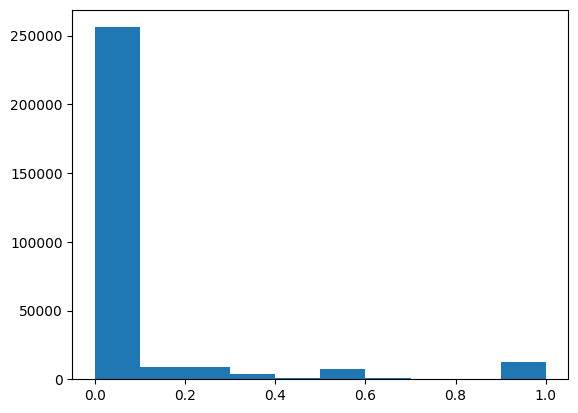

HSA


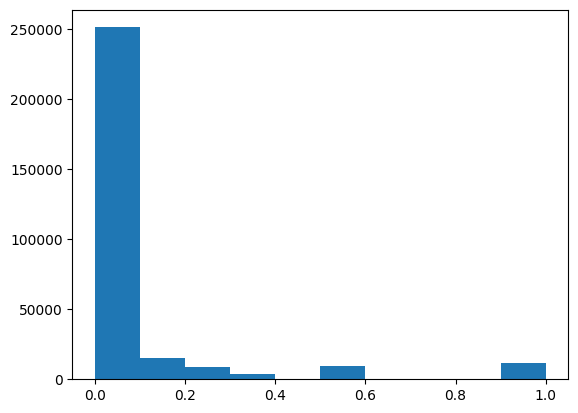

sEH


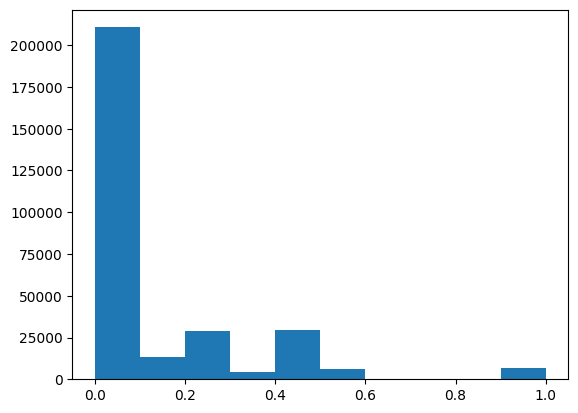

In [12]:
from matplotlib import pyplot as plt

for protein in ['BRD4', 'HSA', 'sEH']:
    print(protein)
    plt.hist(tmp_df[protein])
    plt.show()

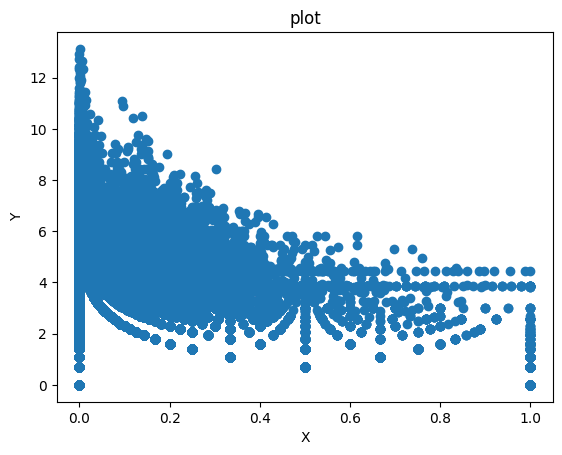

In [13]:
scatter_plot(tmp_df['sEH'], tmp_df['count'].log())

BRD4
HSA
sEH


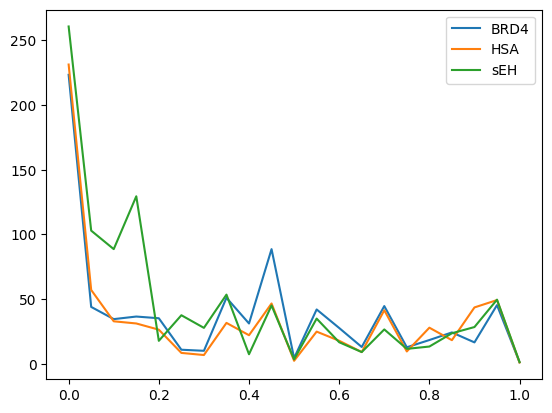

In [14]:
for protein in ['BRD4', 'HSA', 'sEH']:
    print(protein)
    tmp = tmp_df.with_columns((pl.col(protein) // 0.05).alias('bin')).group_by('bin').agg(pl.col('count').mean()).sort('bin')
    plt.plot(tmp['bin'] * 0.05, tmp['count'])
plt.legend(['BRD4', 'HSA', 'sEH'])

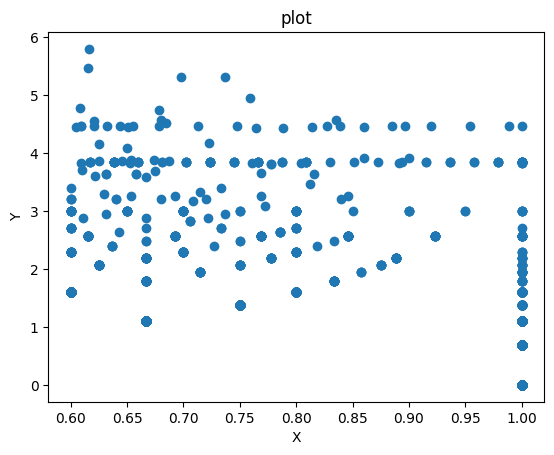

scaffold_idx,BRD4,HSA,sEH,mol_per_scaf,count
i64,f64,f64,f64,u32,u32
5445847,0.0,0.0,1.0,1,1
3334936,0.0,1.0,1.0,1,1
3951145,0.0,0.0,1.0,1,1
2549769,0.0,0.0,1.0,1,1
4063609,0.0,0.0,1.0,1,1
4304537,0.0,1.0,1.0,1,1
785301,0.0,0.0,1.0,1,1
41685,0.0,0.0,1.0,1,1
2156922,0.0,0.0,1.0,1,1


In [15]:
tmp = tmp_df.filter(pl.col('sEH') >= 0.6).sort('count')
scatter_plot(tmp['sEH'], tmp['count'].log())
tmp

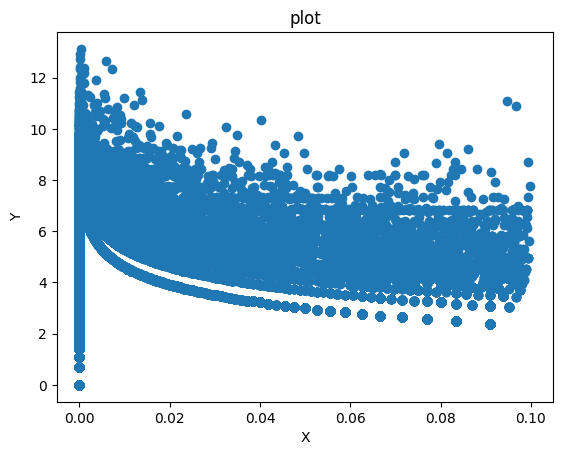

scaffold_idx,BRD4,HSA,sEH,mol_per_scaf,count
i64,f64,f64,f64,u32,u32
3198219,1.0,0.0,0.0,1,1
5132175,0.0,1.0,0.0,1,1
4527765,1.0,0.0,0.0,1,1
5641681,0.0,1.0,0.0,1,1
1003027,0.0,1.0,0.0,1,1
2952316,1.0,0.0,0.0,1,1
3453301,0.0,1.0,0.0,1,1
1506897,1.0,0.0,0.0,1,1
4070034,1.0,0.0,0.0,1,1


In [16]:
tmp = tmp_df.filter(pl.col('sEH') < 0.1).sort('count')
scatter_plot(tmp['sEH'], tmp['count'].log())
tmp

In [17]:
train_df

molecule,bb1,bb2,bb3,BRD4,HSA,sEH,scaffold_idx,mol_per_scaf
str,u16,u16,u16,u8,u8,u8,i64,u32
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,4283326,843
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,4486646,9415
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,1015728,9006
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,196,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,253,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,1219,0,0,0,5301385,26751
"""C#CCOc1ccc(CNc…",1640,1653,604,0,0,0,543172,842


In [18]:
train_df = train_df.with_columns(
    pl.any_horizontal('BRD4', 'HSA', 'sEH').cast(pl.UInt8).alias('label')).with_columns(
    pl.col('BRD4').sum().over('scaffold_idx').alias('pos_BRD4_mol_per_scaf'),
    pl.col('HSA').sum().over('scaffold_idx').alias('pos_HSA_mol_per_scaf'),
    pl.col('sEH').sum().over('scaffold_idx').alias('pos_sEH_mol_per_scaf'),
    pl.col('label').sum().over('scaffold_idx').alias('pos_mol_per_scaf'),
)

train_df

molecule,bb1,bb2,bb3,BRD4,HSA,sEH,scaffold_idx,mol_per_scaf,label,pos_BRD4_mol_per_scaf,pos_HSA_mol_per_scaf,pos_sEH_mol_per_scaf,pos_mol_per_scaf
str,u16,u16,u16,u8,u8,u8,i64,u32,u8,i64,i64,i64,i64
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,4283326,843,0,41,3,1,45
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,4486646,9415,0,98,1,11,110
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,1015728,9006,0,190,1,74,265
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,5301385,26751,0,635,4,146,780
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,5301385,26751,0,635,4,146,780
"""C#CCOc1ccc(CNc…",1640,1653,196,0,0,0,5301385,26751,0,635,4,146,780
"""C#CCOc1ccc(CNc…",1640,1653,253,0,0,0,5301385,26751,0,635,4,146,780
"""C#CCOc1ccc(CNc…",1640,1653,1219,0,0,0,5301385,26751,0,635,4,146,780
"""C#CCOc1ccc(CNc…",1640,1653,604,0,0,0,543172,842,0,25,2,0,27


In [19]:
train_df.filter(pl.col('pos_mol_per_scaf') == 0).select(pl.n_unique('molecule', 'scaffold_idx'))

molecule,scaffold_idx
u32,u32
42695137,5410825


5410825/5711873 (94.7294%) scaffolds are all negative

(array([5.41023e+06, 4.26000e+02, 1.24000e+02, 2.60000e+01, 6.00000e+00,
        1.10000e+01, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.00000e+00, 1.47270e+03, 2.94440e+03, 4.41610e+03, 5.88780e+03,
        7.35950e+03, 8.83120e+03, 1.03029e+04, 1.17746e+04, 1.32463e+04,
        1.47180e+04]),
 <BarContainer object of 10 artists>)

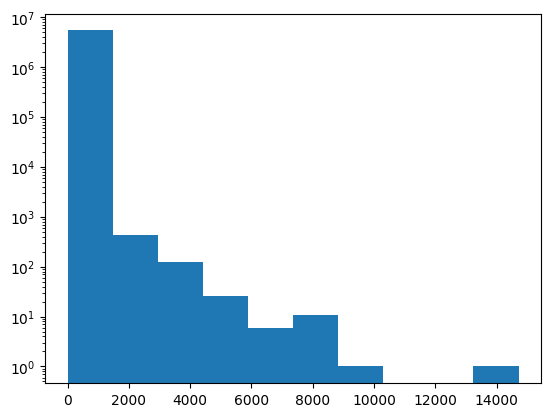

In [20]:
tmp_df = train_df.filter(pl.col('pos_mol_per_scaf') == 0).group_by('scaffold_idx').agg(pl.col('mol_per_scaf').first())
plt.hist(tmp_df['mol_per_scaf'], log = True)

In [21]:
tmp_df['mol_per_scaf'].mean(), tmp_df['mol_per_scaf'].median(), tmp_df['mol_per_scaf'].max()

(7.890688942998526, 2.0, 14718)

In [22]:
tmp_df = train_df.filter(pl.col('pos_mol_per_scaf') > 0).group_by('scaffold_idx').agg(pl.col('mol_per_scaf').first(),
                                                                                     pl.col('pos_mol_per_scaf').first())
tmp_df

scaffold_idx,mol_per_scaf,pos_mol_per_scaf
i64,u32,i64
3242527,94,1
422340,36,1
991752,11,1
4767770,4,1
2009064,592,5
5045402,140,4
3305967,5,1
4224707,3,1
5945787,4,1


(array([3.00941e+05, 7.30000e+01, 1.80000e+01, 6.00000e+00, 5.00000e+00,
        1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([1.0000e+00, 6.5230e+02, 1.3036e+03, 1.9549e+03, 2.6062e+03,
        3.2575e+03, 3.9088e+03, 4.5601e+03, 5.2114e+03, 5.8627e+03,
        6.5140e+03]),
 <BarContainer object of 10 artists>)

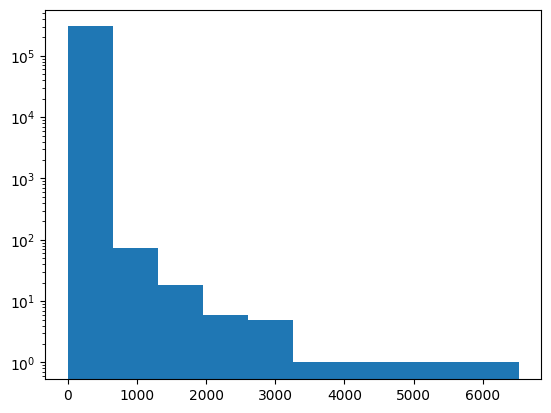

In [23]:
plt.hist(tmp_df['pos_mol_per_scaf'], log = True)

(array([129212.,  49459.,  22683.,  41576.,  22827.,   1718.,   1936.,
          1262.,    420.,  29955.]),
 array([9.28246542e-05, 1.00083542e-01, 2.00074260e-01, 3.00064977e-01,
        4.00055695e-01, 5.00046412e-01, 6.00037130e-01, 7.00027847e-01,
        8.00018565e-01, 9.00009282e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

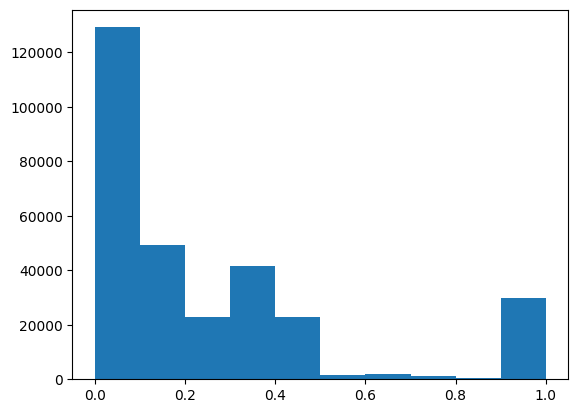

In [24]:
plt.hist(tmp_df['pos_mol_per_scaf'] / tmp_df['mol_per_scaf'], log = False)

In [25]:
tmp_df = tmp_df.with_columns((pl.col('pos_mol_per_scaf') / pl.col('mol_per_scaf')).alias('pos_ratio_per_scaf'))

In [26]:
tmp_df.filter(pl.col('pos_mol_per_scaf') == 6514)

scaffold_idx,mol_per_scaf,pos_mol_per_scaf,pos_ratio_per_scaf
i64,u32,i64,f64
5114213,65818,6514,0.09897


In [27]:
tmp_df.shape

(301048, 4)

In [28]:
train_df['label'].mean()

0.015340848875498511

In [29]:
tmp_df.filter((pl.col('pos_ratio_per_scaf') >= 0.9) & (pl.col('mol_per_scaf') >= 50))

scaffold_idx,mol_per_scaf,pos_mol_per_scaf,pos_ratio_per_scaf
i64,u32,i64,f64
897637,87,82,0.942529
2671746,86,78,0.906977
5689881,87,81,0.931034
3951295,87,86,0.988506
5051066,97,88,0.907216
2217833,50,45,0.9
267005,97,88,0.907216
4075663,87,83,0.954023
1524870,87,80,0.91954


In [30]:
tmp_df['pos_mol_per_scaf'].mean(), \
tmp_df['pos_mol_per_scaf'].median(), \
tmp_df['pos_mol_per_scaf'].max(), \
tmp_df['mol_per_scaf'].mean(), \
tmp_df['mol_per_scaf'].median(), \
tmp_df['mol_per_scaf'].max(), \
tmp_df['pos_ratio_per_scaf'].mean(), \
tmp_df['pos_ratio_per_scaf'].median()

(5.015077329861019,
 1.0,
 6514,
 185.08833475060456,
 13.0,
 499089,
 0.2627146191906659,
 0.16666666666666666)

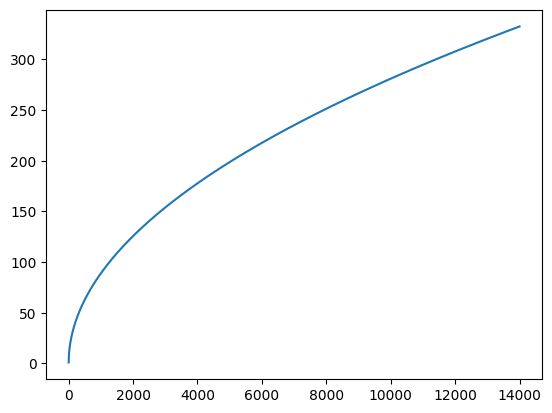

In [32]:
import math

    
def make_intra_group_pos_weight(pos_mol_per_scaf, mol_per_scaf, min_pos_ratio = 0.1, max_pos_ratio = 0.9):
    pos_ratio = pos_mol_per_scaf / mol_per_scaf
    if pos_ratio == 0:
        return 0.0
    elif pos_ratio == 1:
        return 1.0
    else:
        return min(max(pos_ratio, min_pos_ratio), max_pos_ratio)
    
    
def make_neg_inter_group_weight(mol_per_scaf, base = 7.890688942998526, mode = 'poly', log_base = None, poly_degree = 0.5):
    if mol_per_scaf <= base:
        return mol_per_scaf
    if mode == 'log':
        log_base = log_base or math.e
        return base * (math.log(mol_per_scaf / base, log_base) + 1)
    elif mode == 'poly':
        # 1.0 is linear
        poly_degree = poly_degree or 1.0
        return base * (mol_per_scaf / base) ** poly_degree
    else:
        raise ValueError
        

def make_inter_group_weight(pos_mol_per_scaf, mol_per_scaf):
    if pos_mol_per_scaf == 0:
        return make_neg_inter_group_weight(mol_per_scaf, base = 7.890688942998526, mode = 'poly', poly_degree = 0.5)
    else:
        # keep all pos
        intra_pos_weight = make_intra_group_pos_weight(pos_mol_per_scaf, mol_per_scaf)
        return pos_mol_per_scaf / intra_pos_weight

x = np.arange(1, 14000)
y = [make_neg_inter_group_weight(e, mode = 'poly', poly_degree = 0.5) for e in x]
plt.plot(x, y)

In [ ]:
train_df

In [34]:
train_df = train_df.with_columns(pl.struct(['pos_mol_per_scaf', 'mol_per_scaf']).map_elements(
    lambda x: make_inter_group_weight(x['pos_mol_per_scaf'], x['mol_per_scaf']), return_dtype = pl.Float32).alias('inter_group_weight'))

In [35]:
train_df = train_df.with_columns(pl.struct(['pos_mol_per_scaf', 'mol_per_scaf']).map_elements(
    lambda x: make_intra_group_pos_weight(x['pos_mol_per_scaf'], x['mol_per_scaf']), return_dtype = pl.Float32).alias('intra_group_weight'))

In [39]:
train_df = train_df.with_columns(
    pl.when(pl.col('label') == 1).then(
        pl.col('inter_group_weight') * pl.col('intra_group_weight') / pl.col('pos_mol_per_scaf')).otherwise(
        pl.col('inter_group_weight') * (1.0 - pl.col('intra_group_weight')) / (pl.col('mol_per_scaf') - pl.col('pos_mol_per_scaf'))
    ).alias('sample_weight')
)
train_df

molecule,bb1,bb2,bb3,BRD4,HSA,sEH,scaffold_idx,mol_per_scaf,label,pos_BRD4_mol_per_scaf,pos_HSA_mol_per_scaf,pos_sEH_mol_per_scaf,pos_mol_per_scaf,inter_group_weight,intra_group_weight,sample_weight
str,u16,u16,u16,u8,u8,u8,i64,u32,u8,i64,i64,i64,i64,f32,f32,f64
"""C#CCOc1ccc(CNc…",1640,1653,765,0,0,0,4283326,843,0,41,3,1,45,450.0,0.1,0.507519
"""C#CCOc1ccc(CNc…",1640,1653,205,0,0,0,4486646,9415,0,98,1,11,110,1100.0,0.1,0.106394
"""C#CCOc1ccc(CNc…",1640,1653,1653,0,0,0,1015728,9006,0,190,1,74,265,2650.0,0.1,0.272852
"""C#CCOc1ccc(CNc…",1640,1653,146,0,0,0,5301385,26751,0,635,4,146,780,7800.0,0.1,0.270301
"""C#CCOc1ccc(CNc…",1640,1653,439,0,0,0,5301385,26751,0,635,4,146,780,7800.0,0.1,0.270301
"""C#CCOc1ccc(CNc…",1640,1653,196,0,0,0,5301385,26751,0,635,4,146,780,7800.0,0.1,0.270301
"""C#CCOc1ccc(CNc…",1640,1653,253,0,0,0,5301385,26751,0,635,4,146,780,7800.0,0.1,0.270301
"""C#CCOc1ccc(CNc…",1640,1653,1219,0,0,0,5301385,26751,0,635,4,146,780,7800.0,0.1,0.270301
"""C#CCOc1ccc(CNc…",1640,1653,604,0,0,0,543172,842,0,25,2,0,27,270.0,0.1,0.29816


(array([4.2695137e+07, 5.3968569e+07, 9.1266800e+05, 3.3136300e+05,
        2.9932300e+05, 9.9974000e+04, 3.7910000e+04, 1.8902000e+04,
        1.1310000e+04, 4.0454000e+04]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

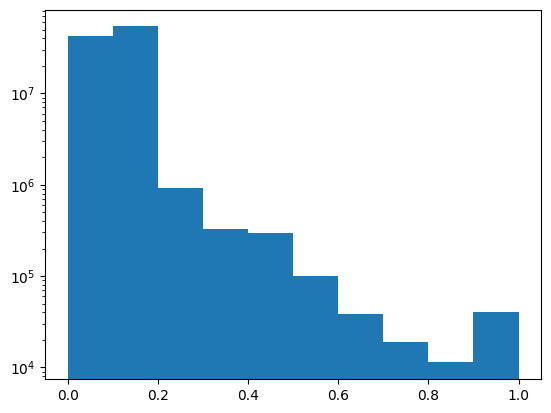

In [41]:
plt.hist(train_df['intra_group_weight'], log = True)

(array([9.4222456e+07, 1.8949360e+06, 5.8428700e+05, 1.9505400e+05,
        1.0170030e+06, 3.8229600e+05, 0.0000000e+00, 0.0000000e+00,
        5.3760000e+04, 6.5818000e+04]),
 array([1.00000000e+00, 6.51489990e+03, 1.30287998e+04, 1.95426992e+04,
        2.60565996e+04, 3.25705000e+04, 3.90843984e+04, 4.55983008e+04,
        5.21121992e+04, 5.86261016e+04, 6.51400000e+04]),
 <BarContainer object of 10 artists>)

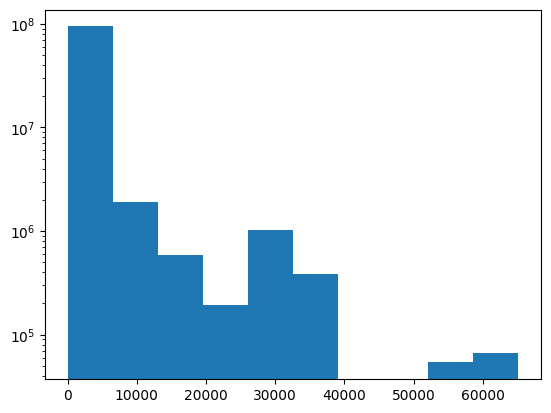

In [44]:
plt.hist(train_df['inter_group_weight'], log = True)

(array([8.4094985e+07, 1.4320595e+07, 1.8000000e+01, 4.0000000e+00,
        1.0000000e+00, 6.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]),
 array([8.35499443e-04, 9.56307770e-01, 1.91178004e+00, 2.86725231e+00,
        3.82272458e+00, 4.77819685e+00, 5.73366912e+00, 6.68914139e+00,
        7.64461366e+00, 8.60008593e+00, 9.55555820e+00]),
 <BarContainer object of 10 artists>)

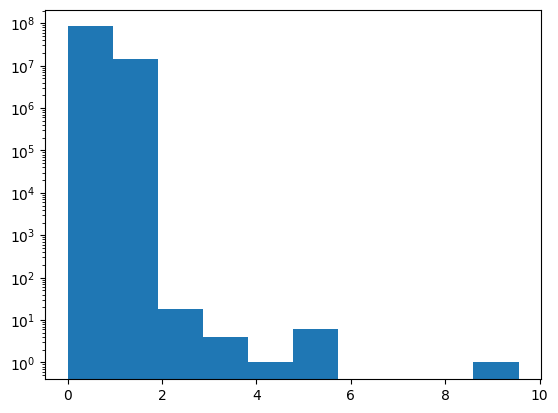

In [47]:
plt.hist(train_df['sample_weight'], log = True)

In [53]:
train_df.shape

(98415610, 17)

In [54]:
analyze_sample_weight(train_df)

BRD4 0.014448811387579806
HSA 0.012913575375656095
sEH 0.02290908303554082
Union: 0.047737922495750755


In [55]:
!mkdir /home/dangnh36/datasets/competitions/leash_belka/processed/sample_weights/

In [57]:
train_df.select('sample_weight').write_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/sample_weights/scaffold_v1.csv')

# Sample weight by Baseline

In [4]:
df = pl.scan_csv('/home/dangnh36/datasets/competitions/leash_belka/processed/train_v3.csv').select(
                                     pl.col('BRD4', 'HSA',
                                            'sEH').cast(pl.UInt8),
                                     pl.col('BRD4_baseline', 'HSA_baseline',
                                            'sEH_baseline')).collect()
df

BRD4,HSA,sEH,BRD4_baseline,HSA_baseline,sEH_baseline
u8,u8,u8,f64,f64,f64
0,0,0,0.000002,0.000047,0.000008
0,0,0,0.000002,0.000029,0.000008
0,0,0,6.5125e-8,0.000007,0.000006
0,0,0,1.4169e-7,0.000001,0.000002
0,0,0,2.8887e-7,0.000006,0.000003
0,0,0,3.1989e-7,0.000011,0.000006
0,0,0,2.3713e-7,0.000007,0.000007
0,0,0,4.0376e-7,0.00001,0.000006
0,0,0,0.000001,0.000034,0.000006


In [5]:
PROTEINS = ['BRD4', 'HSA', 'sEH']
BASELINE_COLS = [f'{protein}_baseline' for protein in PROTEINS]

In [ ]:
# df[BASELINE_COLS].to_pandas().hist(bins = 50, log = True, figsize = (20, 15))

In [6]:
df[BASELINE_COLS].describe(percentiles = PERCENTILES)

statistic,BRD4_baseline,HSA_baseline,sEH_baseline
str,f64,f64,f64
"""count""",9.841561e7,9.841561e7,9.841561e7
"""null_count""",0.0,0.0,0.0
"""mean""",0.000017,0.000083,0.000019
"""std""",0.000441,0.000975,0.000415
"""min""",0.0,0.0,0.0
"""1%""",4.2266e-9,1.7573e-7,6.1547e-9
"""2.5%""",1.1823e-8,4.1410e-7,1.7956e-8
"""5%""",3.0127e-8,9.1994e-7,6.4347e-8
"""10%""",9.1774e-8,0.000002,3.4208e-7


In [9]:
tmp = df.filter(pl.col('BRD4_baseline') > 0.0)['BRD4_baseline']
tmp.max() / tmp.mean()

57149.65025596602